In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import stackprinter
import seaborn as sns
from itertools import chain
import os
from PIL import Image
import torchvision
from torchvision.utils import save_image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
stackprinter.set_excepthook(style='darkbg2')

In [3]:
mypath = '/Users/tommy84729/Coding/DL/ＨＷ2/data'
fileList = os.listdir(mypath)
fileList.remove('.DS_Store')

## data pre-processing

In [4]:
def data_preprocessing(mypath,filelist, height, width) : 
    data = []
    for i in range(len(filelist)) : 
        path_=os.path.join(mypath,fileList[i])
        img = Image.open(path_).convert("RGB").resize((height,width))
        a = np.transpose(np.array(img)).astype(np.float32)/255
        data.append(a)
        if (i+1)%1000 == 0 : 
            print(i)
    return data

In [5]:
height = 28
width = 28
data = data_preprocessing(mypath, fileList, height, width)

999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
17999
18999
19999
20999


In [7]:
np.savez('/Users/tommy84729/coding/DL/ＨＷ2/data.npz', data = data)

In [ ]:
_,ax = plt.subplots(8,8, figsize = (8,8)) 
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(data[8*i+j])
        ax[i,j].axis('off')
plt.show()

In [96]:
batch_size = 64
data = np.array(data)
feature_train = torch.from_numpy(data)
train = torch.utils.data.TensorDataset(feature_train)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

## Model

In [57]:
image_size =  height * width
h_dim = 400
z_dim = 20
epoch = 10
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [97]:
class VAE(nn.Module) : 
    def __init__(self, image_size = image_size , h_dim = h_dim , z_dim = z_dim) : 
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x) : 
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var) : 
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        
        return(mu + eps*std)
    
    def decode(self, z) : 
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x) : 
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return mu, log_var , x_reconst

In [98]:
model = VAE().to(device).float()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train

In [99]:
total_loss = []
for i in range(epoch):
    running_loss = 0
    for  x in train_loader:
        # Forward pass
        x = x[0].to(device).view(-1, image_size)
        mu,log_var, x_reconst = model(x.float())
        reconst_loss = F.binary_cross_entropy(x_reconst, x.float(), size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div.item()
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss.append(running_loss)
    print(f'epoch: {i+1}/{epoch}', end = '\r')
        

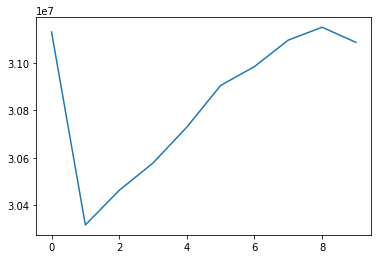

In [100]:
plt.plot(total_loss)

## sample 

In [103]:
with torch.no_grad():
  # Save the sampled images
    z = torch.randn(1,batch_size, z_dim).to(device)
    out = model.decode(z).view(-1, 3, height, width)
    save_image(out, os.path.join('/Users/tommy84729/python/DL/ＨＷ2','sampled-{}.png'.format(epoch+1)))

In [104]:
Image.fromarray(np.transpose(data[1])*255, 'RGB')

In [105]:
 _ , _ , out = model(x.float())
out = out.view(-1, 3, 28, 28).float()
x = x.view(-1, 3, 28, 28).float()
save_image(out, os.path.join('/Users/tommy84729/python/DL/ＨＷ2','compare_model-{}.png'.format(epoch+1)))
save_image(x, os.path.join('/Users/tommy84729/python/DL/ＨＷ2','compare_x-{}.png'.format(epoch+1)))

RuntimeError: size mismatch, m1: [3948 x 28], m2: [2352 x 400] at ../aten/src/TH/generic/THTensorMath.cpp:41